# Traffic Flow Forecasting

## Objective 

Our main goal is to **forecast twelve-hours of traffic flow in a major U.S. metropolitan area** and model interactions across a network of roadways, using a time series labelled dataset with both location coordinates and a direction of travel.

## Dataset Descriptions
`train.csv` : the training set, comprising measurements of traffic congestion across 65 roadways from April through September of 1991. 
- row_id: a unique identifier for this instance 
- time: the 20-minute period in which each measurement was taken 
- x: the east-west midpoint coordinate of the roadway 
- y: the north-south midpoint coordinate of the roadway 
- direction: the direction of travel of the roadway. EB indicates "eastbound" travel, for example, while SW indicates a "southwest" direction of travel congestion 
- congestion: levels for the roadway during each hour; the target. The congestion measurements have been normalized to the range 0 to 100.
`test.csv` : the test set; you will make hourly predictions for roadways identified by a coordinate location and a direction of travel on the day of 1991-09-30.

`sample_submission.csv` : a sample submission file in the correct format.

In [2]:
!pip install kaggle

     |████████████████████████████████| 58 kB 8.9 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73052 sha256=47ccd98884b3887edc9846e70ea3dbff1e34d9bde574fc36ee2cee8916e9eb5a
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [8]:
!cp /work/kaggle.json ~/.kaggle/kaggle.json

In [9]:
!kaggle competitions download -c tabular-playground-series-mar-2022

  0%|                                               | 0.00/4.71M [00:00<?, ?B/s]
100%|███████████████████████████████████████| 4.71M/4.71M [00:00<00:00, 103MB/s]


In [10]:
!unzip /work/tabular-playground-series-mar-2022.zip -d /work/dados/

Archive:  /work/tabular-playground-series-mar-2022.zip
  inflating: /work/dados/sample_submission.csv  
  inflating: /work/dados/test.csv    
  inflating: /work/dados/train.csv   


In [12]:
# imports

import pandas as pd

### Loading the data

In [14]:
train_df = pd.read_csv('/work/dados/train.csv')
test_df = pd.read_csv('/work/dados/test.csv')

In [15]:
train_df.head(10)

,row_id,time,x,y,direction,congestion
0,0,1991-04-01 00:00:00,0,0,EB,70
1,1,1991-04-01 00:00:00,0,0,NB,49
2,2,1991-04-01 00:00:00,0,0,SB,24
3,3,1991-04-01 00:00:00,0,1,EB,18
4,4,1991-04-01 00:00:00,0,1,NB,60
5,5,1991-04-01 00:00:00,0,1,SB,58
6,6,1991-04-01 00:00:00,0,1,WB,26
7,7,1991-04-01 00:00:00,0,2,EB,31
8,8,1991-04-01 00:00:00,0,2,NB,49
9,9,1991-04-01 00:00:00,0,2,SB,46


<AxesSubplot:>

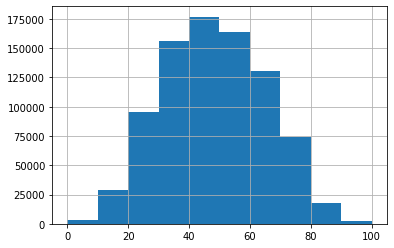

In [16]:
train_df['congestion'].hist()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3035cbe1-744b-40d6-9d24-00f96529caea' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>